### General imports and definitions

In [68]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

from dirty_completeness import injection

cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

# Load the dataset
df = pd.read_csv("../datasets/abalone.csv")

# After quick inspection we see that all columns will contain missing values
missing_columns = list(df.columns)

# Get one hot encoding of column 0
one_hot = pd.get_dummies(df['0'])

# Drop column 0 as it is now encoded
df_dropped = df.drop('0',axis = 1)
display(df)
display(df_dropped)

,0,1,2,3,4,5,6,7
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


,1,2,3,4,5,6,7
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [69]:
def compute_clustering_scores(df, clusters, n_clusters=3):

    # Visualize the clusters using t-SNE
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(df)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis')
    plt.show()

    # Compute the silhouette score
    silhouette = silhouette_score(df, clusters)
    print("Silhouette score: {:.3f}".format(silhouette))
    # Compute the Calinski-Harabasz index
    calinski = calinski_harabasz_score(df, clusters)
    print("Calinski-Harabasz index: {:.3f}".format(calinski))

    return silhouette,calinski

### K-Prototypes

In [70]:
# Standardize numerical features only
scaler = StandardScaler()
X_num = scaler.fit_transform(df_dropped)
X_num = pd.DataFrame(X_num, columns=df_dropped.columns)
X_num.describe()

,1,2,3,4,5,6,7
count,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03
mean,-5.834718e-16,-3.027929e-16,3.912493e-16,9.185853e-17,-1.020650e-17,2.704723e-16,2.976897e-16
std,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00
min,-3.739154e+00,-3.556267e+00,-3.335953e+00,-1.686092e+00,-1.614731e+00,-1.643173e+00,-1.705134e+00
25%,-6.161975e-01,-5.833158e-01,-5.862075e-01,-7.897577e-01,-7.811585e-01,-7.946415e-01,-7.819095e-01
50%,1.749513e-01,1.725193e-01,1.156329e-02,-5.963767e-02,-1.052891e-01,-8.753202e-02,-3.470794e-02
75%,7.579031e-01,7.267984e-01,6.093341e-01,6.613049e-01,6.426730e-01,6.606355e-01,6.478319e-01
max,2.423480e+00,2.440025e+00,2.368329e+01,4.072271e+00,5.085388e+00,5.286500e+00,5.504642e+00


In [71]:
# Recompose the dataset
X = pd.concat([df["0"], X_num], axis=1)

# Get the position of categorical columns
catColumnsPos = [X.columns.get_loc(col) for col in list(X.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(X.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

# Convert dataframe to matrix
dfMatrix = X.to_numpy()
X

Categorical columns           : ['0']
Categorical columns position  : [0]


,0,1,2,3,4,5,6,7
0,M,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,M,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,F,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,M,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,I,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,F,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062
4173,M,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685
4174,M,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955
4175,F,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739


Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6


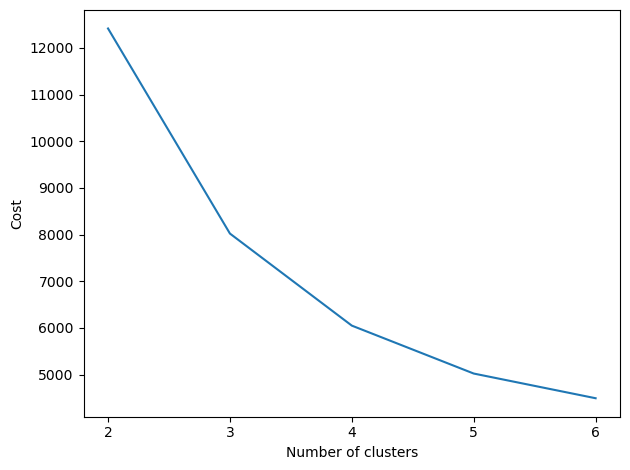

In [73]:
from kmodes.kprototypes import KPrototypes

# Choose optimal K using Elbow method
cost = []
for cluster in range(2, 7):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except Exception as e: 
        print(e)

fig, ax = plt.subplots()
ax.plot(range(2, 7), cost)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Cost')
plt.xticks(range(2, 7))
plt.tight_layout()
plt.show()

We decide to go for k=3

In [74]:
k = 3

# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
len(kprototype.labels_)

4177

Centroids interpretation

In [75]:
# Add the cluster to the dataframe
X['Cluster Labels'] = kprototype.labels_
X['Segment'] = X['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
# Order the cluster
X['Segment'] = X['Segment'].astype('category')
X['Segment'] = X['Segment'].cat.reorder_categories(['First','Second','Third'])

# Cluster interpretation
X.groupby('Segment').agg(
    {
        'Cluster Labels':'count',
        '1': 'mean',
        '2': 'mean',
        '3': 'mean',
        '4': 'mean',
        '5': 'mean',
        '6': 'mean',
        '7': 'mean',
        '0': pd.Series.mode,
    }
).reset_index()

,Segment,Cluster Labels,1,2,3,4,5,6,7,0
0,First,1262,-1.227690,-1.229269,-1.069729,-1.111289,-1.064053,-1.089888,-1.096015,I
1,Second,1135,1.068016,1.072152,1.006233,1.272729,1.233929,1.254744,1.217399,F
2,Third,1780,0.189408,0.187891,0.116811,-0.023652,-0.032402,-0.027357,0.000799,M


PCA visualization

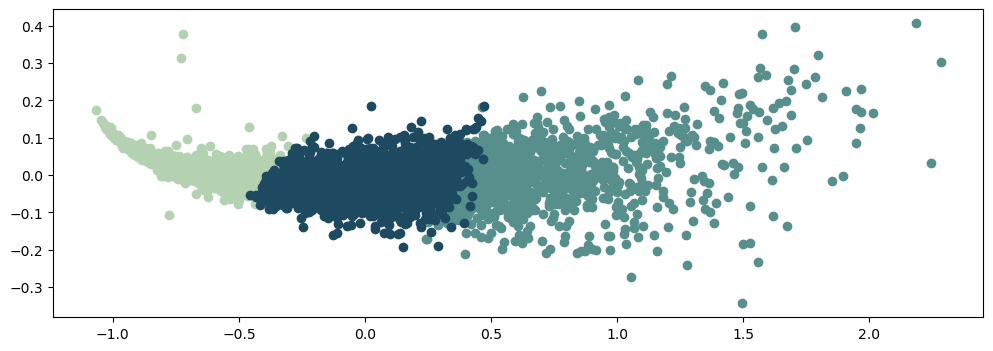

In [76]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(df_dropped)

for l, c in zip(range(k), cluster_colors[:k]):
    ax.scatter(X_pca[X['Cluster Labels'] == l, 0], X_pca[X['Cluster Labels'] == l, 1], color=c)

plt.show()

#### Results:

c:\Users\tomma\anaconda3\envs\diq\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\tomma\anaconda3\envs\diq\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


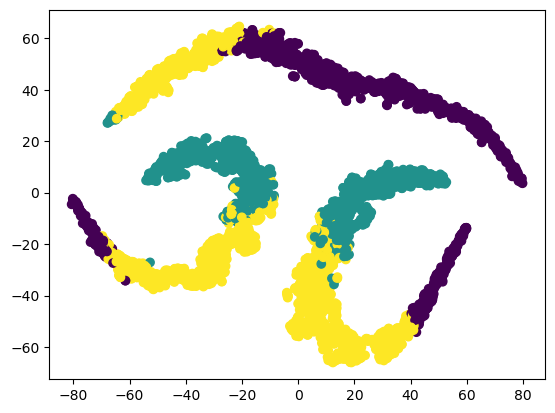

Silhouette score: 0.197
Calinski-Harabasz index: 1282.147


(0.19708039293742463, 1282.1467785813668)

In [85]:
compute_clustering_scores(pd.get_dummies(df), kprototype.labels_)

### DBSCAN

In [78]:
scaler = StandardScaler()
X_num = scaler.fit_transform(df_dropped)
X_num = pd.DataFrame(X_num, columns=df_dropped.columns)
X_all = pd.concat([df["0"], X_num], axis=1)
X_all

,0,1,2,3,4,5,6,7
0,M,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,M,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,F,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,M,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,I,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,F,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062
4173,M,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685
4174,M,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955
4175,F,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739


Since we need to handle categorical data we'll use a different distance metric, the Gower distance

In [79]:
import gower

X = gower.gower_matrix(X_all)
X.shape

(4177, 4177)

In [80]:
from sklearn.cluster import DBSCAN

# eps and min_samples have been tuned manually
db = DBSCAN(eps = 0.1, min_samples = 5, metric = "precomputed").fit(X)
X_all['Cluster Labels'] = db.labels_

# Check how many clusters we have identified
labels = X_all['Cluster Labels'].unique()
labels

array([ 0,  1,  2, -1], dtype=int64)

PCA visualization

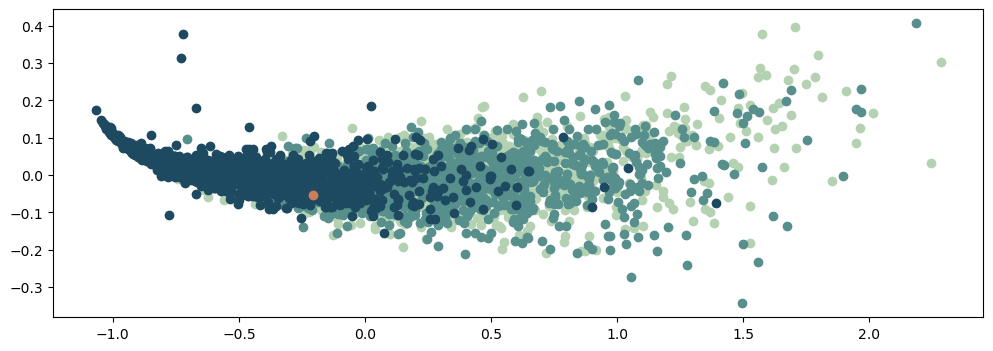

In [81]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(df_dropped)

for l, c in zip(labels, cluster_colors[:len(labels)]):
    ax.scatter(X_pca[X_all['Cluster Labels'] == l, 0], X_pca[X_all['Cluster Labels'] == l, 1], color=c)

plt.show()

While with respect to the Gower distances

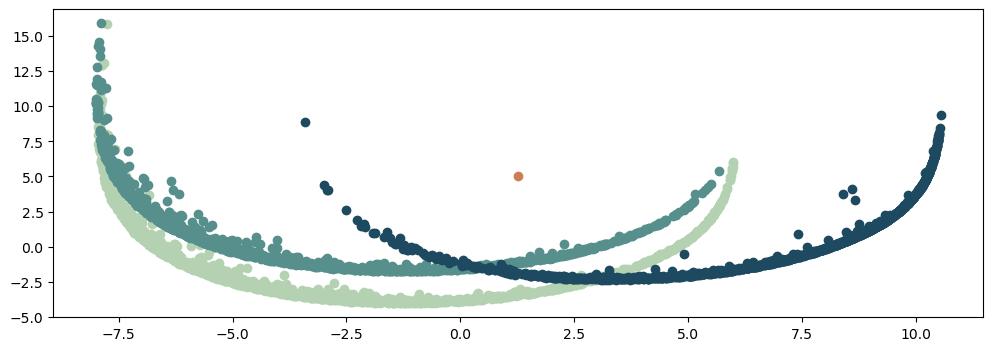

In [82]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X)

for l, c in zip(labels, cluster_colors[:len(labels)]):
    ax.scatter(X_pca[X_all['Cluster Labels'] == l, 0], X_pca[X_all['Cluster Labels'] == l, 1], color=c)

plt.show()

#### Results:

c:\Users\tomma\anaconda3\envs\diq\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\tomma\anaconda3\envs\diq\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


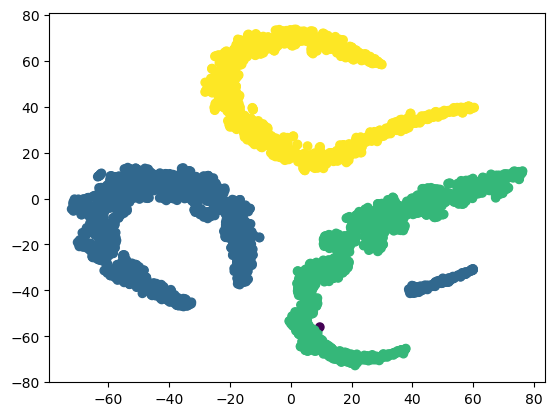

Silhouette score: 0.614
Calinski-Harabasz index: 4466.042


(0.6140489868441068, 4466.041964044207)

In [84]:
compute_clustering_scores(pd.get_dummies(df), db.labels_)

### Imputation

In [87]:
# Obtain the list of null-injected datasets
perc = [0.50, 0.40, 0.30, 0.20, 0.10]
df_list = injection(df, 42, "abalone", "None")

print("\nMissing values per column for each version:")
for ds in df_list:
    print(list(ds.isnull().sum()))

# Decide on which version we'll apply our imputation algorithms
test_ind = 4  # must be between 0 and 4

saved abalone-completeness50%
saved abalone-completeness60%
saved abalone-completeness70%
saved abalone-completeness80%
saved abalone-completeness90%

Missing values per column for each version:
[2082, 2149, 2107, 2102, 2008, 2022, 2134, 2081]
[1704, 1672, 1674, 1732, 1625, 1633, 1690, 1656]
[1215, 1244, 1273, 1241, 1266, 1280, 1316, 1252]
[836, 823, 862, 868, 834, 873, 836, 815]
[402, 416, 406, 379, 404, 425, 424, 399]


In [90]:
# this function accounts for nan even if in our case they are not present. This has been done to follow the lecture approach.
def compute_accuracy(ground_truth, imputed):

    # defining not nulls in the ground truth
    not_nan = ~pd.isna(ground_truth)
    # counting total not nan
    total = np.count_nonzero(not_nan)
    # compare ground_truth and imputed values where there are not nan
    correct = np.count_nonzero((ground_truth[not_nan] == imputed[not_nan]))

    # compute the accuracy
    accuracy = correct / total
    return accuracy

Single imputation with mode

Accuracy: 0.909


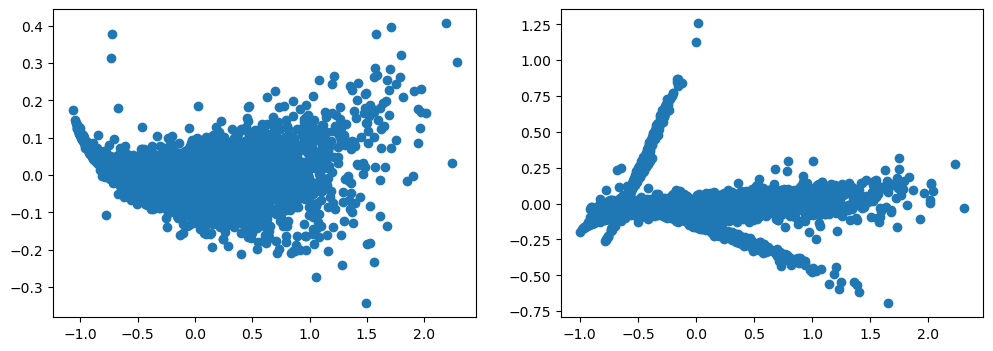

In [92]:
df_test = pd.DataFrame(columns = [name for name in missing_columns])
for col in missing_columns:
    df_test[col] = df_list[test_ind][col].fillna(df_list[test_ind][col].mode()[0])

# Accuracy assessment
print(f'Accuracy: {compute_accuracy(df, df_test):.3f}')

# Visualization of the results
fig, axes = plt.subplots(1, 2, figsize=(12,4))

pca = PCA(n_components=2,random_state=42)

X_pca = pca.fit_transform(df.drop('0',axis = 1))
axes[0].scatter(X_pca[:, 0], X_pca[:, 1])

X_pca = pca.fit_transform(df_test.drop('0',axis = 1))
axes[1].scatter(X_pca[:, 0], X_pca[:, 1])

plt.show()

MICE on the numerical values + classifier (KNNeighbors) for the categorical feature

c:\Users\tomma\anaconda3\envs\diq\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(3775, 7) (3775,)

Accuracy: 0.910


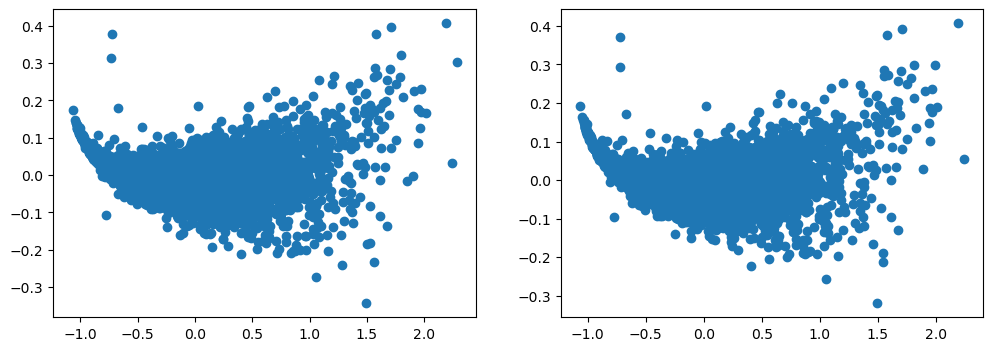

In [104]:
import math

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor

df_cat = df_list[test_ind]['0']
df_num = df_list[test_ind].drop('0',axis = 1)

# Apply MICE on df_num
multivariate_impute_pipe = ColumnTransformer([
                                            ("impute_num", 
                                            IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=10),max_iter=100), 
                                            df_num.columns)
                                            ])
                                            
df_mice = multivariate_impute_pipe.fit_transform(df_num)

# Prepare the matrixes for the classifier (since NaN targets will be ignored, the accuracy of the classifier will depend on the percentage of missing values)
y = []
X = []
for t, x in zip(df_cat, df_mice):
    if t == 'M':
        y.append(0.)
        X.append(x)
    elif t == 'I':
        y.append(1.)
        X.append(x)
    elif t == 'F':
        y.append(2.)
        X.append(x)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

# Train the classifier (we can also try other kinds of classifiers)
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=10)

classifier.fit(X, y)

# Use the classifier to predict only missing targets
df_cat_imp = []
for t, x in zip(df_cat, df_mice):
    if t == 'M' or t == 'I' or t == 'F':
        df_cat_imp.append(t)
    else:
        t = classifier.predict(x.reshape(1, -1))
        if t == 0.:
            df_cat_imp.append('M')
        elif t == 1.:
            df_cat_imp.append('I')
        elif t == 2.:
            df_cat_imp.append('F')

# Recompose the dataset
df_mice = pd.DataFrame(df_mice, columns=df_num.columns)
df_cat_imp = pd.DataFrame(df_cat_imp, columns=['0'])
df_test = df_cat_imp.join(df_mice)

# Accuracy assessment
print(f'\nAccuracy: {compute_accuracy(df, df_test):.3f}')

# Visualization of the results
fig, axes = plt.subplots(1, 2, figsize=(12,4))

pca = PCA(n_components=2,random_state=42)

X_pca = pca.fit_transform(df.drop('0', axis = 1))
axes[0].scatter(X_pca[:, 0], X_pca[:, 1])

X_pca = pca.fit_transform(df_test.drop('0', axis = 1))  # categorical features are dropped to allow visual comparison
axes[1].scatter(X_pca[:, 0], X_pca[:, 1])

plt.show()